In [96]:
%matplotlib inline
import json
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from nltk import bigrams
import matplotlib.pyplot as plt

In [2]:
tips_data = eval(open('test_tips.txt', encoding = 'utf-8').read())

In [8]:
l = 0
for threads in tips_data.keys():
    l += len(tips_data[threads]['messages'].keys())

In [19]:
users = []
status = []
dates = []
messages = []
for threads in tips_data.keys():
    thread = tips_data[threads]
    for msg in thread['messages']:
        users.append(thread['messages'][msg]['user'])
        status.append(thread['messages'][msg]['user_status'])
        dates.append(thread['messages'][msg]['date'])
        messages.append(thread['messages'][msg]['message'])

In [24]:
import pandas as pd

In [26]:
data = pd.DataFrame({
    'user':users,
    'status':status,
    'date':dates,
    'message':messages,
})

In [27]:
data.shape

(22137, 4)

In [28]:
data.dtypes

user       object
status     object
date       object
message    object
dtype: object

In [42]:
stop_words = stopwords.words('english') + list(string.punctuation)

In [55]:
users_list = data.user.values

In [29]:
""" this fucntion is used to apply all the cleaning steps to the data text columns"""
def data_cleaning(combined_text):
    text = combined_text.lower() #converts everything to lower case charecters
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)#replaces all the punctuations with none
    text = re.sub('\w*\d\w*', '', text) #removes all the numbers
    text = text.replace('\n','') #replaces all the tab charecters
    text = text.replace('\t','')#replaces all the tab charecters
    text = [i for i in word_tokenize(text) if i not in stop_words] #removing stop words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text] #Lemmantizing every word
    
    return text

In [43]:
data['cleaned_message'] = data.message.apply(lambda x: data_cleaning(x))

In [47]:
from textblob import TextBlob

In [51]:
msg_polrity = []
for text in data.cleaned_message:
    polarity_analysis = TextBlob(' '.join(text))
    msg_polrity.append(polarity_analysis.sentiment.polarity)

In [52]:
data['polarity'] = msg_polrity

In [54]:
data.head(10)

,user,status,date,message,cleaned_message,polarity
0,FormerTaxiDriver♧,Well-Known Member,2019-02-28T03:38:38-0800,"MARYVILLE, Tenn. (AP) - A Tennessee man was ja...","[maryville, tenn, ap, tennessee, man, jailed, ...",-0.091667
1,Cableguynoe,Well-Known Member,2019-02-28T04:21:27-0800,But how was the salsa?,[salsa],0.000000
2,FormerTaxiDriver♧,Well-Known Member,2019-02-28T04:23:43-0800,\n\nCableguynoe said:\n\n\n\n\t\t\tBut how was...,"[cableguynoe, saidbut, salsaclick, expanddisap...",0.000000
3,MoonlightingPHD,Well-Known Member,2019-02-28T05:17:12-0800,Terrible article--they don't even state if it ...,"[terrible, articlethey, dont, even, state, hot...",-0.138889
4,Slave2daEats,Member,2019-02-28T06:15:46-0800,The delivery service really dropped the ball w...,"[delivery, service, really, dropped, ball, one]",0.200000
5,jlong105,Well-Known Member,2019-02-28T06:17:46-0800,\n\nCableguynoe said:\n\n\n\n\t\t\tBut how was...,"[cableguynoe, saidbut, salsaclick, expandit, k...",0.600000
6,1.5xorbust,Well-Known Member,2019-02-28T06:30:57-0800,Why would anyone only dip their testicles?,"[would, anyone, dip, testicle]",0.000000
7,BikingBob,Well-Known Member,2019-02-28T07:08:22-0800,\n\nFormerTaxiDriver♧ said:\n\n\n\n\t\t\tDinne...,"[formertaxidriver♧, saiddinner, delivered, sai...",0.275000
8,TomTheAnt,Well-Known Member,2019-02-28T09:03:49-0800,\n\nFormerTaxiDriver♧ said:\n\n\n\n\t\t\tposte...,"[formertaxidriver♧, saidposted, video, onlinec...",0.000000
9,mrpjfresh,Well-Known Member,2019-02-28T09:46:25-0800,""" Oooohhhh, it feels good on my balls!"" Lol. ...","[oooohhhh, feel, good, ball, lol, kinky, perve...",0.375000


In [ ]:
import gensim
from sklearn.model_selection import train_test_split

In [64]:
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [65]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data.cleaned_message.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [70]:
embeddings = get_word2vec_embeddings(word2vec, data)

In [71]:
import pickle

In [73]:
classifier_model = pickle.load(open('sentiment_predictor.sav','rb'))

In [75]:
data['predicted_sentiment'] = classifier_model.predict(embeddings)

In [83]:
data.date = pd.to_datetime(data.date)

In [84]:
data.head()

,user,status,date,message,cleaned_message,polarity,predicted_sentiment
0,FormerTaxiDriver♧,Well-Known Member,2019-02-28 11:38:38,"MARYVILLE, Tenn. (AP) - A Tennessee man was ja...","[maryville, tenn, ap, tennessee, man, jailed, ...",-0.091667,negative
1,Cableguynoe,Well-Known Member,2019-02-28 12:21:27,But how was the salsa?,[salsa],0.000000,negative
2,FormerTaxiDriver♧,Well-Known Member,2019-02-28 12:23:43,\n\nCableguynoe said:\n\n\n\n\t\t\tBut how was...,"[cableguynoe, saidbut, salsaclick, expanddisap...",0.000000,positive
3,MoonlightingPHD,Well-Known Member,2019-02-28 13:17:12,Terrible article--they don't even state if it ...,"[terrible, articlethey, dont, even, state, hot...",-0.138889,negative
4,Slave2daEats,Member,2019-02-28 14:15:46,The delivery service really dropped the ball w...,"[delivery, service, really, dropped, ball, one]",0.200000,positive


In [86]:
data.groupby('predicted_sentiment').agg({'message':'count'}).rename(columns = {'message':'count'})

,count
predicted_sentiment,
negative,14032
positive,8105


In [88]:
""" This function uses the word cloud package to create a word cloud plot which helps in visualizing """

def word_cloud_plot(text, title = "Word Cloud", mask = None):
    try:
        word_cloud = WordCloud(width=1600, height=800, max_font_size=200, mask = mask).generate(text)
    except:
        word_cloud = WordCloud(width=1600, height=800, max_font_size=200, mask = mask).fit_words(text)
        
    plt.figure(figsize=(20,15))
    plt.title(title, size = 25)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()   

In [89]:
"""This function takes in any text blob, tokenizes the blob and then extracts the bigrams from the same. 
It also gives back the Bigram count dictionary"""

def string_bigram_frequency(text_blob):
    
    tokens = word_tokenize(text_blob) #from the NLTK package
    bi_grams = []
    for txt in list(bigrams(tokens)): #bigrams is also from the NLTK package
        bi_grams.append((''.join([word + ' ' for word in txt])).strip())
    
    all_tokens = bi_grams  + tokens
    count_dict = Counter(all_tokens) #counter is from the collections package
    
    return count_dict

In [94]:
msg_count = string_bigram_frequency(' '.join([' '.join(text) for text in data.cleaned_message]))

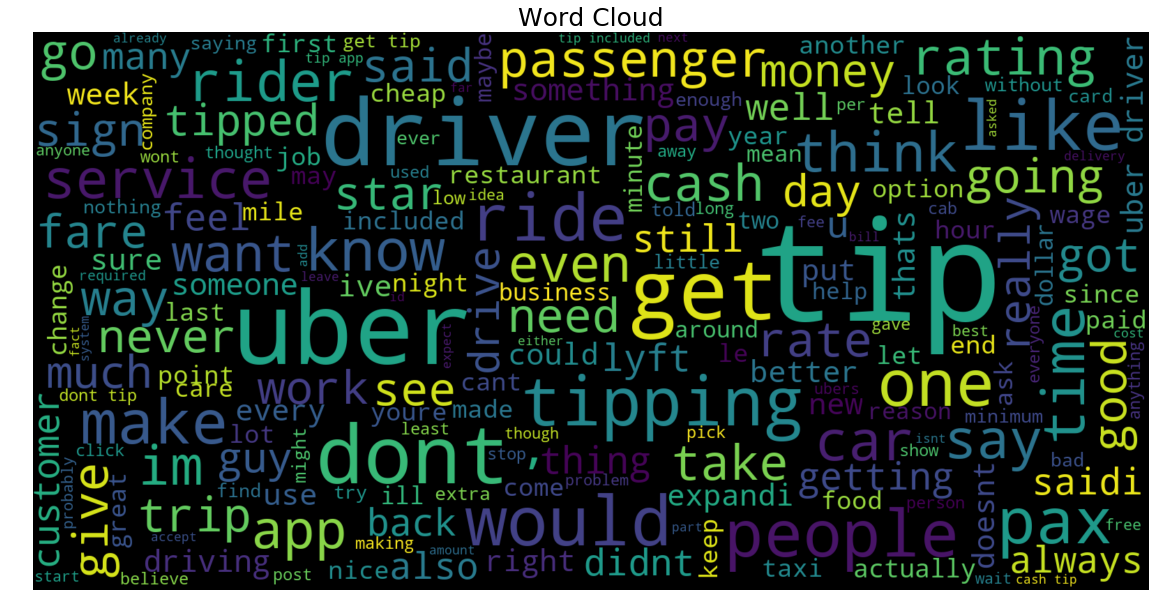

In [98]:
word_cloud_plot(msg_count)

In [100]:
data['year'] = data.date.apply(lambda x: x.year)
data['month'] = data.date.apply(lambda x: x.month)

In [102]:
data.groupby('year')['message'].count()

year
2014     843
2015    2943
2016    5098
2017    6507
2018    4810
2019    1936
Name: message, dtype: int64

In [107]:
sentiment_cat = []
for sentiment in data.predicted_sentiment:
    if sentiment == 'positive':
        sentiment_cat.append(1)
    else:
        sentiment_cat.append(-1)
        
data['pred_cat'] = sentiment_cat        

In [113]:
data.groupby('year')['pred_cat'].sum()

year
2014    -419
2015    -907
2016   -1734
2017   -1751
2018    -786
2019    -330
Name: pred_cat, dtype: int64

In [115]:
import seaborn as sns

In [129]:
data.set_index(data.date, inplace = True)

In [130]:
data.head()

,user,status,date,message,cleaned_message,polarity,predicted_sentiment,year,month,pred_cat
date,,,,,,,,,,
2019-02-28 11:38:38,FormerTaxiDriver♧,Well-Known Member,2019-02-28 11:38:38,"MARYVILLE, Tenn. (AP) - A Tennessee man was ja...","[maryville, tenn, ap, tennessee, man, jailed, ...",-0.091667,negative,2019,2,-1
2019-02-28 12:21:27,Cableguynoe,Well-Known Member,2019-02-28 12:21:27,But how was the salsa?,[salsa],0.000000,negative,2019,2,-1
2019-02-28 12:23:43,FormerTaxiDriver♧,Well-Known Member,2019-02-28 12:23:43,\n\nCableguynoe said:\n\n\n\n\t\t\tBut how was...,"[cableguynoe, saidbut, salsaclick, expanddisap...",0.000000,positive,2019,2,1
2019-02-28 13:17:12,MoonlightingPHD,Well-Known Member,2019-02-28 13:17:12,Terrible article--they don't even state if it ...,"[terrible, articlethey, dont, even, state, hot...",-0.138889,negative,2019,2,-1
2019-02-28 14:15:46,Slave2daEats,Member,2019-02-28 14:15:46,The delivery service really dropped the ball w...,"[delivery, service, really, dropped, ball, one]",0.200000,positive,2019,2,1


In [160]:
data['concat_month'] = data.year.map(str)+ ' - ' +data.month.map(str)

In [163]:
year_date_sentiment = data.groupby('concat_month', as_index=False).agg({'pred_cat':'sum','polarity':'mean'}).rename(
    columns={'pred_cat':'average_sentiment', 'concat_month':'year_month', 'polarity':'mean_polarity'})

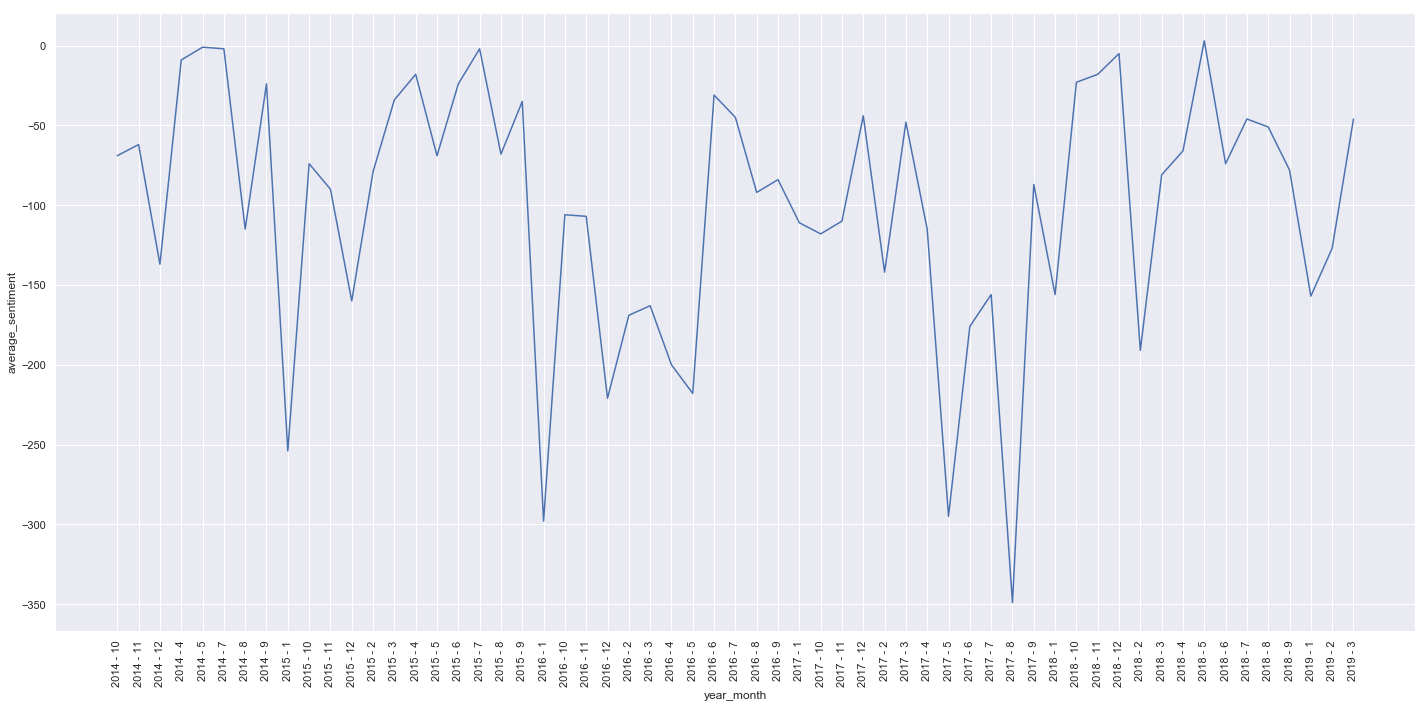

In [184]:
sns.set(style="darkgrid", rc = {'figure.figsize':(20,10)})
sns.lineplot(x = year_date_sentiment.year_month, y = year_date_sentiment.average_sentiment)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('monthly_sentiment.png')

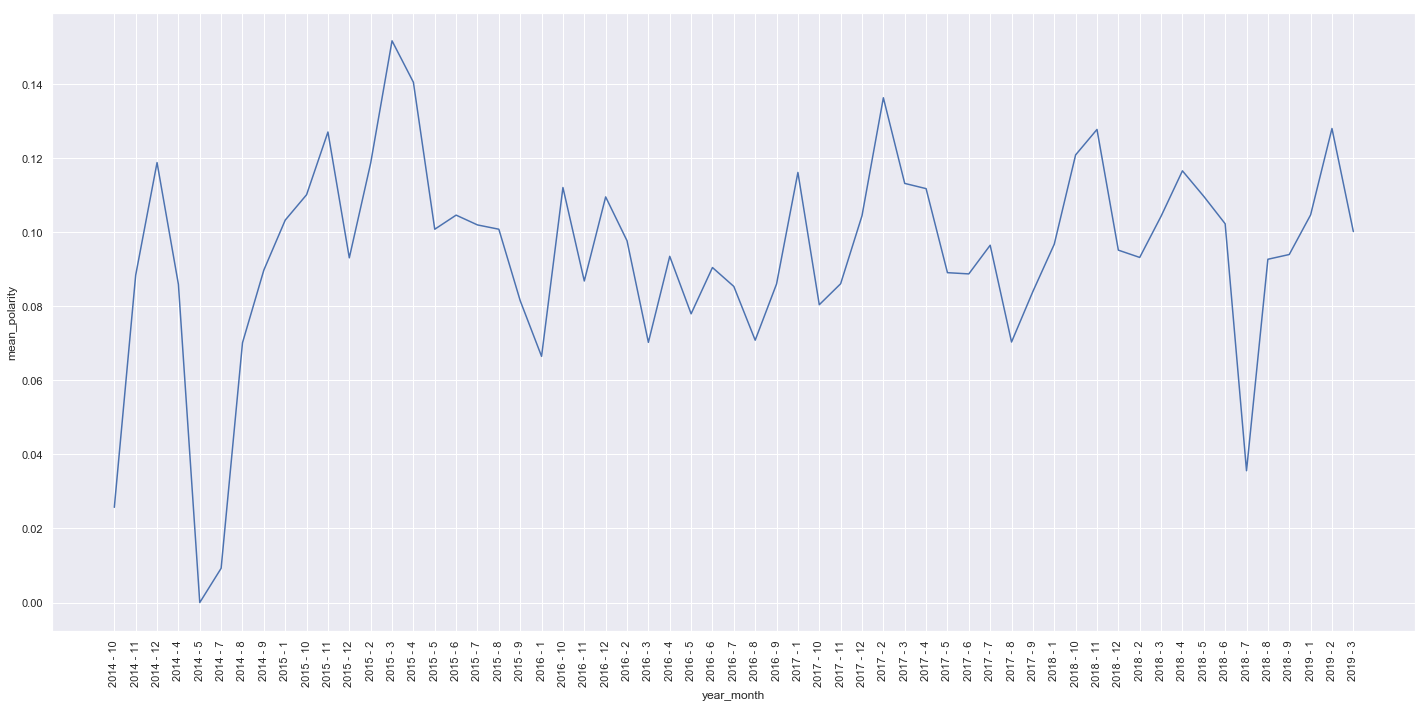

In [165]:
sns.set(style="darkgrid", rc = {'figure.figsize':(20,10)})
sns.lineplot(x = year_date_sentiment.year_month, y = year_date_sentiment.mean_polarity)
plt.xticks(rotation = 90)
plt.tight_layout()

In [158]:
data['quarter'] = data.date.apply(lambda x: x.quarter)

In [168]:
data['concat_quarter'] = data.year.map(str) + ' - ' + data.quarter.map(str)

In [173]:
year_quarter_data = data.groupby('concat_quarter', as_index = False).agg({'pred_cat':'sum','polarity':'mean'}).rename(
    columns={'pred_cat':'average_sentiment', 'concat_quarter':'year_quarter', 'polarity':'mean_polarity'})

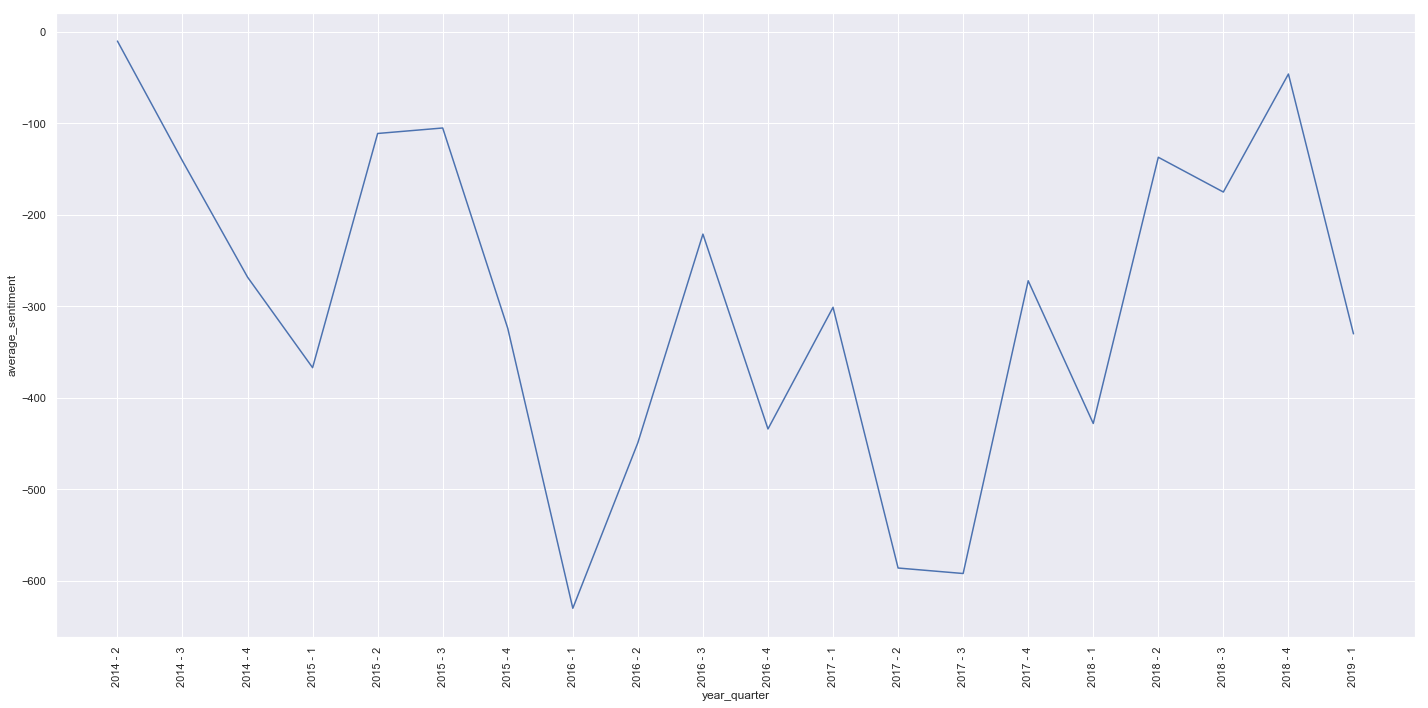

In [185]:
sns.set(style="darkgrid", rc = {'figure.figsize':(20,10)})
sns.lineplot(x = year_quarter_data.year_quarter, y = year_quarter_data.average_sentiment)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('quaterly_sentiment.png')

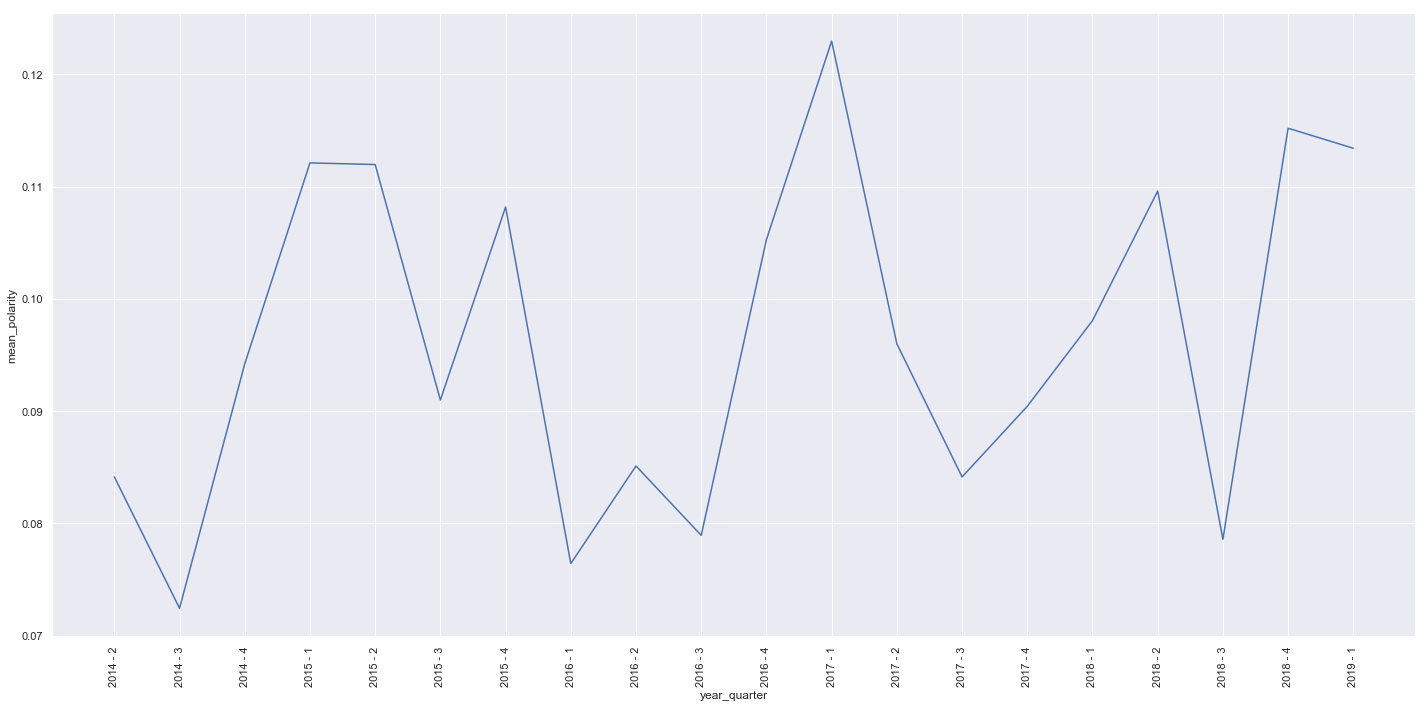

In [175]:
sns.set(style="darkgrid", rc = {'figure.figsize':(20,10)})
sns.lineplot(x = year_quarter_data.year_quarter, y = year_quarter_data.mean_polarity)
plt.xticks(rotation = 90)
plt.tight_layout()

In [181]:
data.groupby('concat_quarter').agg({'pred_cat':'count'})

,pred_cat
concat_quarter,
2014 - 2,48
2014 - 3,233
2014 - 4,562
2015 - 1,1093
2015 - 2,255
2015 - 3,559
2015 - 4,1036
2016 - 1,1526
2016 - 2,1475
